# Wczytanie bibliotek

In [ ]:
import pandas as pd
import numpy as np
import scipy as sc
import plotly.express as px
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# 3. Wstępna ocena przydatności danych

In [9]:
df = pd.read_csv("houses_to_rent_v2.csv")

### Sprawdzenie duplikatów i N/A

In [10]:
df.duplicated().any()
df=df.drop_duplicates()
df.isna().any()

city                   False
area                   False
rooms                  False
bathroom               False
parking spaces         False
floor                  False
animal                 False
furniture              False
hoa (R$)               False
rent amount (R$)       False
property tax (R$)      False
fire insurance (R$)    False
total (R$)             False
dtype: bool

### Statystyki pozycyjne zmiennych numerycznych

In [11]:
df.describe()

,area,rooms,bathroom,parking spaces,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
count,10334.000000,10334.000000,10334.000000,10334.000000,1.033400e+04,10334.000000,10334.000000,10334.000000,1.033400e+04
mean,152.439423,2.539965,2.268725,1.644475,1.091244e+03,3966.296013,376.929263,54.264273,5.488943e+03
std,545.875595,1.168185,1.414650,1.598527,1.144609e+04,3436.190007,3160.602165,48.164380,1.266911e+04
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,59.000000,2.000000,1.000000,1.000000,1.800000e+02,1598.250000,41.000000,21.000000,2.116000e+03
50%,95.000000,3.000000,2.000000,1.000000,5.710000e+02,2750.000000,130.000000,37.000000,3.685500e+03
75%,190.000000,3.000000,3.000000,2.000000,1.286750e+03,5000.000000,389.750000,70.000000,6.912000e+03
max,46335.000000,13.000000,10.000000,12.000000,1.117000e+06,45000.000000,313700.000000,677.000000,1.120000e+06


## Korelacja atrybutów numerycznych

<AxesSubplot: >

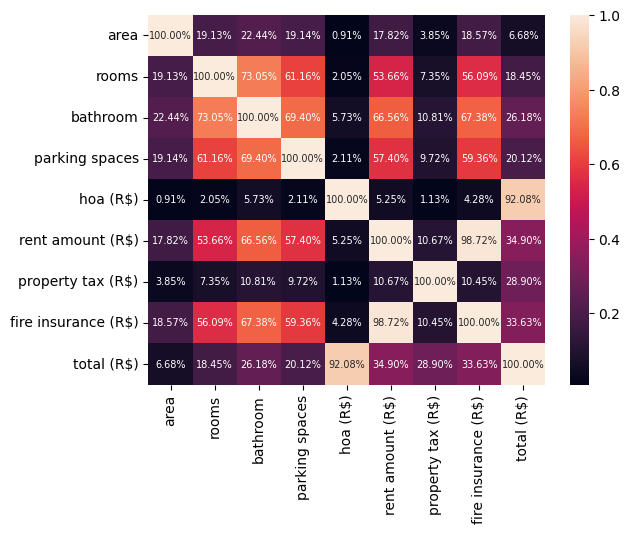

In [12]:
corel = df.corr(numeric_only=True)
sns.heatmap(corel, annot=True,fmt=".2%", annot_kws={"size":7})

Kroki do rozwazenia:\
*Zmiana zmiennych furniture/animal na binarne\
*Usunięcie zmiennych hoa(R$), fire insurance - współliniowość, floor  - 2000 rekordów nie ma dostępnego piętra, total - to samo, co w zmiennych wyzej, tylko dodane do siebie\
*Usunięcie outlierów w rent amount

# 4. Przetwarzanie danych

### Zamiana atrybutów binarnych kategorycznych na binarne numeryczne

In [13]:
df[['FurnitureYES', "FurnitureNO"]] = pd.get_dummies(df.furniture)
df = df.drop(['furniture','FurnitureNO'], axis=1)

In [14]:
df[['AnimalsYES', "AnimalsNO"]] = pd.get_dummies(df.animal)
df = df.drop(['animal','AnimalsNO'], axis=1)

### Usunięcie nieprawidłowych atrybutów numerycznych

In [15]:
df = df.drop(['floor','hoa (R$)', 'total (R$)','city', 'fire insurance (R$)'],axis=1)

### Zmiana nazw kolumn

In [16]:
df.columns = ["Area", "No. of Rooms","No. of Bathrooms",  "No. of Parkings", "Rent Amount (R$)", "Property Tax (R$)", "Furniture", "Animals"]

### Ponowna korelacja atrybutów

<AxesSubplot: >

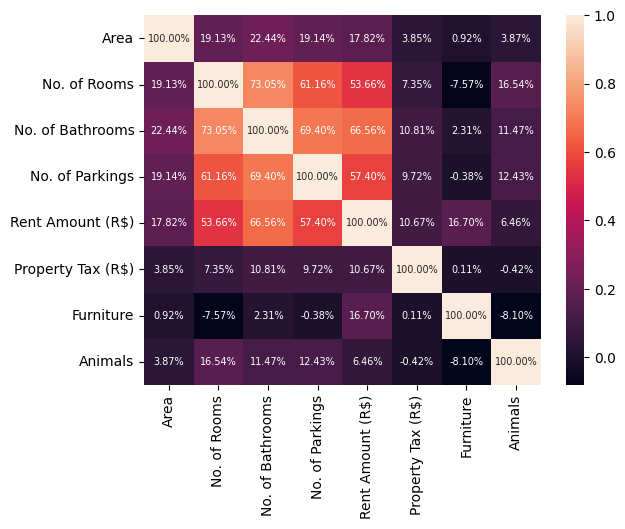

In [17]:
corel = df.corr(numeric_only=True)
sns.heatmap(corel, annot=True, fmt=".2%", annot_kws={"size":7})

### Rozkład atrybutu decyzyjnego

Text(0.5, 1.0, 'Rozkład atrybutu decyzyjnego -  Wysokość czynszu')

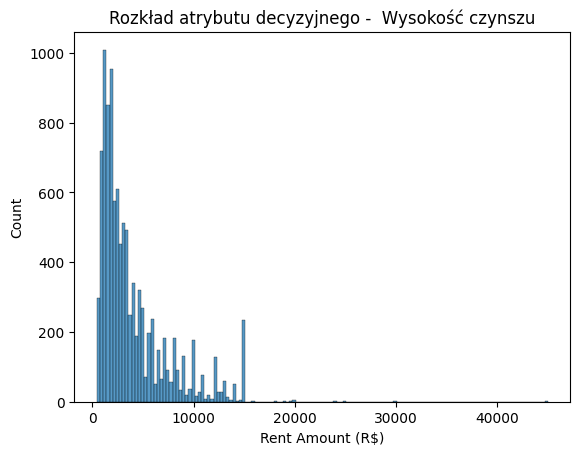

In [20]:
sns.histplot(df["Rent Amount (R$)"])
plt.title("Rozkład atrybutu decyzyjnego -  Wysokość czynszu")

In [21]:
np.percentile(df["Rent Amount (R$)"],98)

15000.0

In [14]:
df = df.query('`Rent Amount (R$)`< 10000')

# 5. Modelowanie

## Definiowanie zbiorów danych

In [78]:
Y = df["Rent Amount (R$)"]
X = df.drop("Rent Amount (R$)", axis=1)

In [91]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 


## Regresja liniowa

### Dodajemy wyraz wolny

In [92]:
x_train = sm.tools.add_constant(x_train)
x_test = sm.tools.add_constant(x_test)
x_val = sm.tools.add_constant(x_val)

In [118]:
reg_lin = sm.OLS(endog=y_train, exog=x_train)
model_lin = reg_lin.fit(cov_type='HAC',cov_kwds={'maxlags':1})
model_lin.rsquared
model_lin.summary()

0.49237768846724406


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Rent Amount (R$)   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     605.7
Date:                Tue, 24 Jan 2023   Prob (F-statistic):               0.00
Time:                        19:45:29   Log-Likelihood:                -71487.
No. Observations:                7750   AIC:                         1.430e+05
Df Residuals:                    7742   BIC:                         1.430e+05
Df Model:                           7                                         
Covariance Type:                  HAC                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -179.9349     79.483     -2.264      0.024    -335.718     -24.152
Area                  0.0847      0.133      0.638      0.523      -0.175       0.345
No. of Rooms        277.7755     47.482      5.850      0.000     184.712     370.839
No. of Bathrooms   1067.6450     43.639     24.465      0.000     982.114    1153.176
No. of Parkings     445.9936     34.566     12.903      0.000     378.246     513.741
Property Tax (R$)     0.0263      0.026      1.002      0.316      -0.025       0.078
Furniture          1262.9735     69.962     18.052      0.000    1125.851    1400.096
Animals             -78.6699     64.558     -1.219      0.223    -205.201      47.861
==============================================================================
Omnibus:                     3337.010   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33892.258
Skew:                           1.789   Prob(JB):                         0.00
Kurtosis:                      12.600   Cond. No.                     1.30e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
[2] The condition number is large, 1.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [94]:
#create instance of influence
influence = reg_lin.get_influence()

#obtain standardized residuals
standardized_residuals = influence.resid_studentized_internal

### Wykres reszt

Text(0.5, 1.0, 'Residuals plot - linear regression')

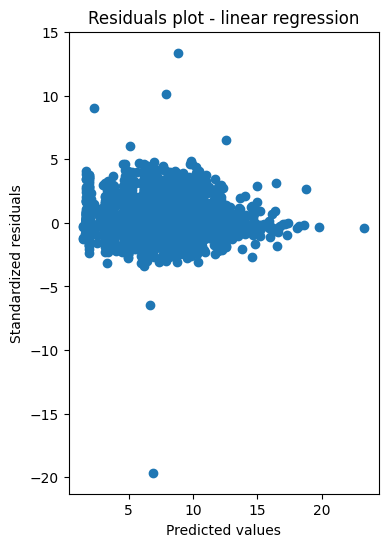

In [95]:
fig1 = plt.figure(figsize=(4, 6))
plt.scatter(x=res.predict(), y=standardized_residuals)
plt.xlabel("Predicted values")
plt.ylabel("Standardized residuals")
plt.title("Residuals plot - linear regression")

### Miary stworzonego modelu

In [126]:
reglin_mse = mean_squared_error(y_train, model_lin.predict())
reglin_mae = sm.tools.eval_measures.meanabs(y_train, model_lin.predict())
reglin_r2 = model_lin.rsquared

In [ ]:
### Usu

## Drzewo regresyjne

In [101]:
regr_tree = DecisionTreeRegressor(max_depth=50)
regr_tree.fit(x_train, y_train)

In [105]:
feature_list = list(x_train.columns)
importances = list(regr_tree.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Area                 Importance: 0.55
Variable: Property Tax (R$)    Importance: 0.27
Variable: No. of Bathrooms     Importance: 0.05
Variable: No. of Parkings      Importance: 0.05
Variable: No. of Rooms         Importance: 0.04
Variable: Furniture            Importance: 0.02
Variable: Animals              Importance: 0.02
Variable: const                Importance: 0.0


Text(0.5, 1.0, 'Estymacja jądrowa dla atrybutu decyzyjnego drzewa regresyjnego')

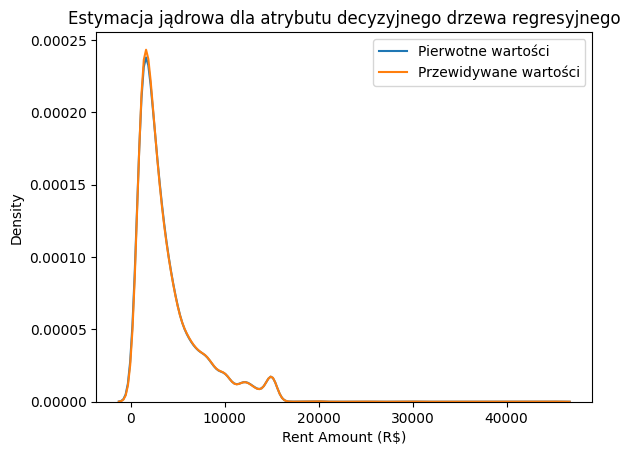

In [124]:
fig1 = sns.kdeplot(y_train)
fig2=sns.kdeplot(predictions)
plt.legend(labels=['Pierwotne wartości', 'Przewidywane wartości'])
plt.title("Estymacja jądrowa dla atrybutu decyzyjnego drzewa regresyjnego")

### Miary stworzonego modelu

In [ ]:
regtree_mse = mean_squared_error(y_train, model_lin.predict())
regtree_mae = sm.tools.eval_measures.meanabs(y_train, model_lin.predict())
regtree_r2 = model_lin.rsquared

## Las losowy

In [30]:
las_los = RandomForestRegressor(n_estimators = 1000, random_state = 18)
reg3 = las_los.fit(x_train, y_train)

In [31]:
las_los.score(x_train,y_train)

0.9394976020025243

In [32]:
feature_list = list(x_train.columns)
importances = list(las_los.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Area                 Importance: 0.55
Variable: Property Tax (R$)    Importance: 0.27
Variable: No. of Bathrooms     Importance: 0.05
Variable: No. of Parkings      Importance: 0.05
Variable: No. of Rooms         Importance: 0.04
Variable: Furniture            Importance: 0.03
Variable: Animals              Importance: 0.02


Text(0.5, 1.0, 'Estymacja jądrowa dla atrybutu decyzyjnego lasu losowego')

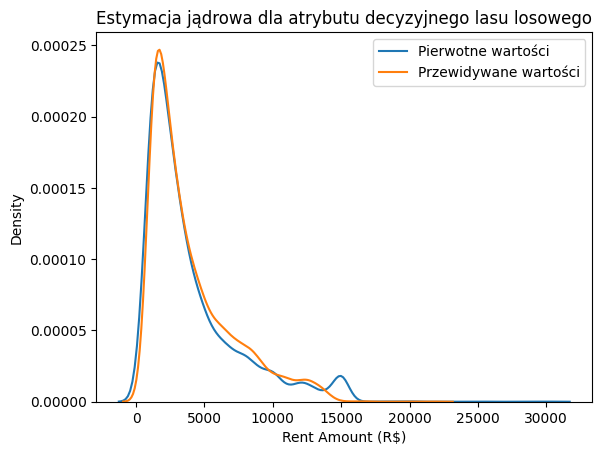

In [33]:
fig1 = sns.kdeplot(y_train)
fig2=sns.kdeplot(las_los.predict(x_train))
plt.legend(labels=['Pierwotne wartości', 'Przewidywane wartości'])
plt.title("Estymacja jądrowa dla atrybutu decyzyjnego lasu losowego")

### Miary modelu - las losowy

mae = sm.tools.eval_measures.meanabs(y_train, las_los.predict(x_train))
r2las = las_los.score()


# 6. Ewaluacja


## Miary

### Regresja liniowa


In [131]:
print(f"MSE regresji liniowej: {round(reglin_mse,2)}")
print(f"MAE regresji liniowej: {round(reglin_mae,2)}")
print(f"R kwadrat: {round(reglin_r2,2)}")

MSE regresji liniowej: 6018644.53
MAE regresji liniowej: 1639.19
R kwadrat: 0.49


In [97]:
print(f"MSE drzewa regresyjnego: {round(reglin_mse,2)}")
print(f"MAE drzewa regresyjnego: {round(reglin_mae,2)}")
print(f"R kwadrat: {round(reglin_r2,2)}")

MSE drzewa regresyjnego: 62.516658452172784
MAE drzewa regresyjnego: 3375.9557686328826


In [ ]:

mae = sm.tools.eval_measures.meanabs(y_train, las_los.predict(x_train))
r2las = las_los.score(x_train,y_train)

print(f"MSE lasu losowego: {mean_squared_error(y_train, las_los.predict(x_train))}")
print(f"MAE lasu losowego: {mae}")
print(f"R kwadrat: {r2las}")

print(f"MSE lasu losowego: {round(reglin_mse,2)}")
print(f"MAE lasu losowego: {round(reglin_mae,2)}")
print(f"R kwadrat: {round(reglin_r2,2)}")